We'll be using differential dynamic microscopy. This technique was first described in 2008 in an article in PRL by Cerbino and Trappe. 
![PRL image](DDM_Paper_PRL.PNG)
You can find the paper [here](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.188102). 

The heart of the DDM code (found in the `ddm_clean.py` file) is the computation of the image structure function. This is found by taking the average of the Fourier transforms of all image *differences*. By "image differences," I mean the result of subtracting two images separated by a given lag time $\Delta t$.

To describe the process mathematically, we find the difference between images separated by some lag time $\Delta t$:
$$\Delta I = I(x,y;t) - I(x,y;t + \Delta t)$$

For a given $\Delta t$ all such image differences are calculated. We then Fourier transform each $\Delta I$ and average all of the same $\Delta t$.

This results in the image structure function $D(q_x,q_y,\Delta t)$.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 6,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 6,
              }

In [3]:
import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

Y:\Pawan K\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
Y:\Pawan K\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
Y:\Pawan K\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


Y:\Pawan K\DDM\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


<IPython.core.display.Javascript object>


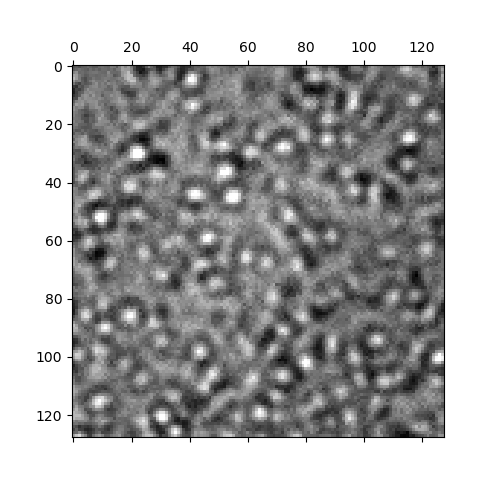

This tif stack has 3000 frames.


In [4]:
#Specify where the data is stored and the image data filename. Must be in tiff format
data_dir = ".\\ExampleData\\"
data_file = "images_nobin_40x_128x128_8bit.tif"

#Image read using tiff_file module
im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

print("This tif stack has %i frames." % im.shape[0])

### Let's look at image *differences*

<IPython.core.display.Javascript object>


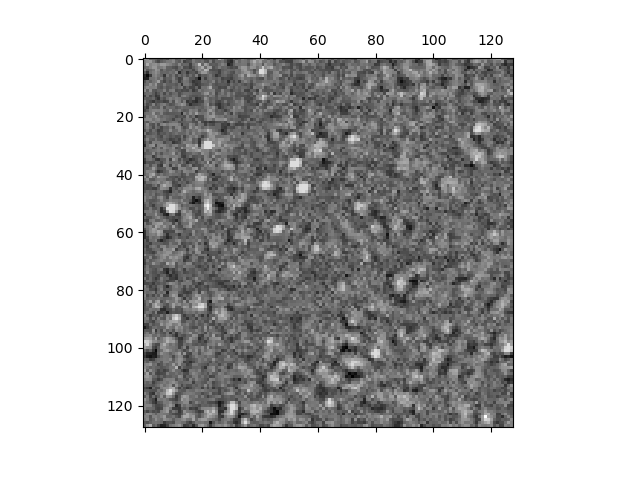

In [5]:
# Here, we show the difference between frames 1 and 2.
# Notice that the second frame is multiplied by 1.0. That is done just so
#  that the matrix will be converted from integers to floating points. 
#  Because we want there to be negative numbers if values in frame 2 are
#  greater than values in frame 1.

plt.figure()
plt.matshow(1.0*im[1]-im[0], fignum=0, cmap=plt.cm.gray)

<IPython.core.display.Javascript object>


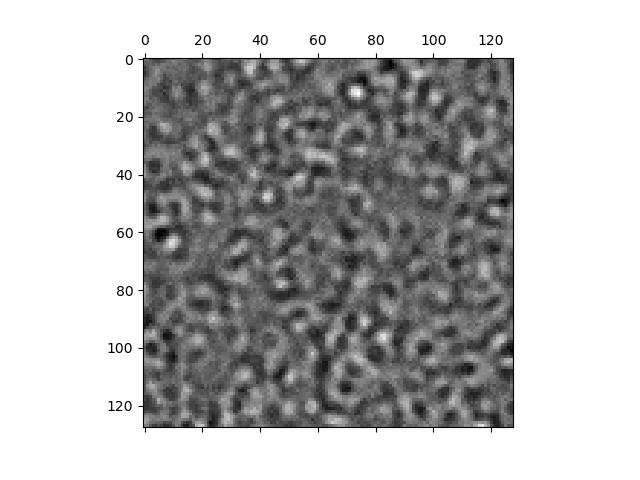

In [6]:
# Here, we show the difference between frames 1 and 50.

plt.figure()
plt.matshow(1.0*im[50]-im[0], fignum=0, cmap=plt.cm.gray)

<IPython.core.display.Javascript object>


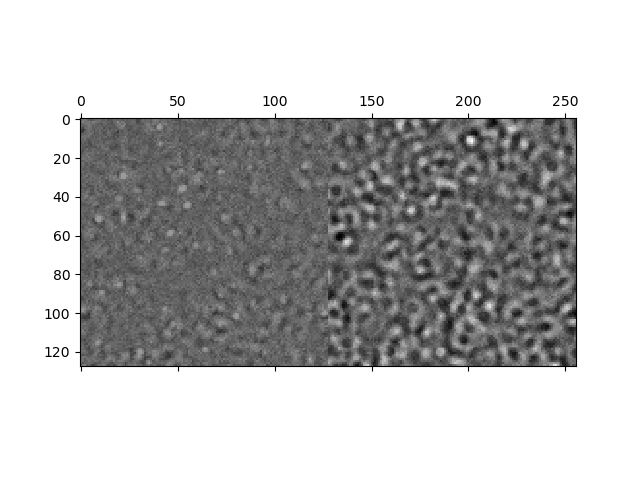

In [7]:
# Let's place those images side-by-side. We'll actually just
#  combine the two matrices with the 'hstack' function in numpy.

plt.figure()
plt.matshow(np.hstack((1.0*im[1]-im[0], 1.0*im[50]-im[0])), fignum=0, cmap=plt.cm.gray)

<IPython.core.display.Javascript object>


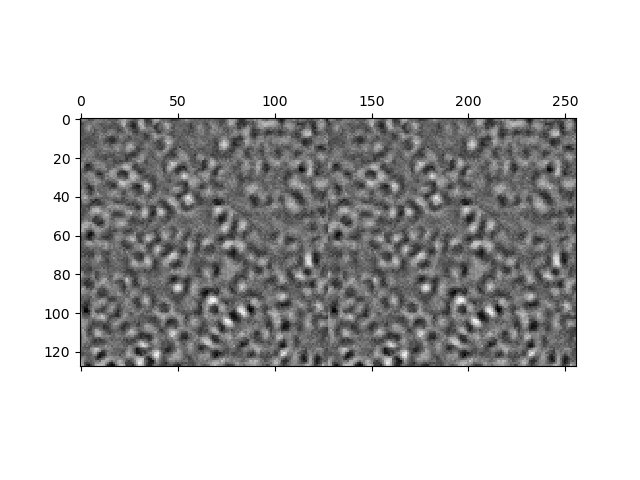

In [21]:
# Do something similar to what was done in the previous code cell.
#   Put show the differences between frames 2 and 1 and between frames
#   100 and 1. 
# Then, in another figure, show the differences between frames 21 and 22
#    and between frame 21 and 120. 

plt.figure()
plt.matshow(np.hstack((1.0*im[10]-1.0*im[0], 1.0*im[10]-im[0])), fignum=0, cmap=plt.cm.gray)
# ... you write the rest

What's different about the image differences with a short lag time separation (1 frame) and the image differences with a longer lag time separation (100 frames?

### Let's look at the Fourier transform of image *differences*

<IPython.core.display.Javascript object>


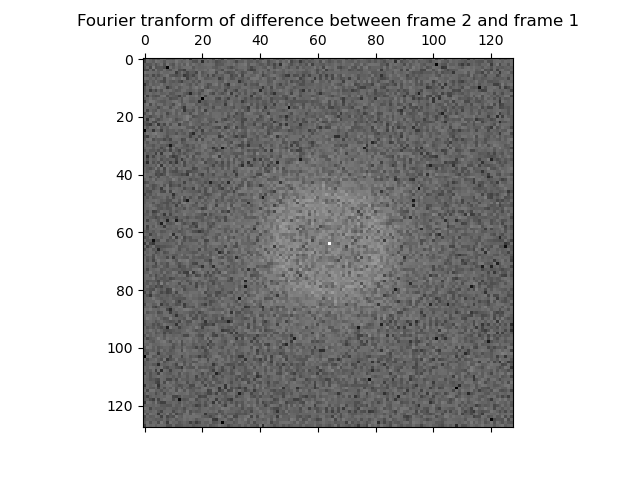

Text(0.5, 1.0, 'Fourier tranform of difference between frame 2 and frame 1')

In [26]:
ft_diff_frame1 = np.fft.fftshift(np.fft.fft2(1.0*im[1]-im[0]))
plt.figure()
plt.matshow(np.log(abs(ft_diff_frame1)), fignum=0, cmap=plt.cm.gray)

# What is the 'np.log' there for??

plt.title("Fourier tranform of difference between frame 2 and frame 1")

<IPython.core.display.Javascript object>


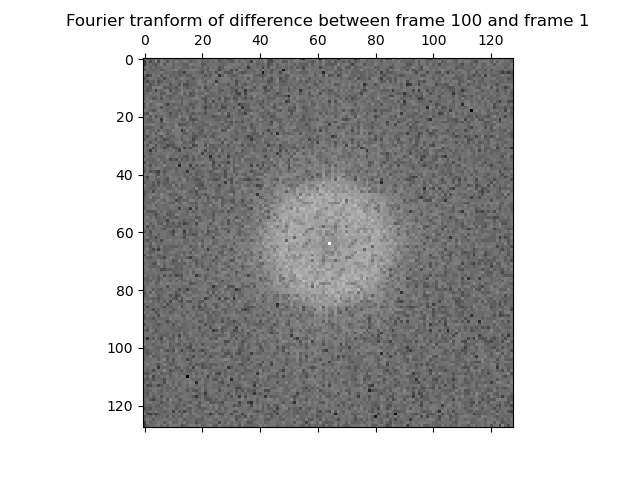

Text(0.5, 1.0, 'Fourier tranform of difference between frame 100 and frame 1')

In [27]:
ft_diff_frame100 = np.fft.fftshift(np.fft.fft2(1.0*im[100]-im[0]))
plt.figure()
plt.matshow(np.log(abs(ft_diff_frame100)), fignum=0, cmap=plt.cm.gray)
plt.title("Fourier tranform of difference between frame 100 and frame 1")

<IPython.core.display.Javascript object>


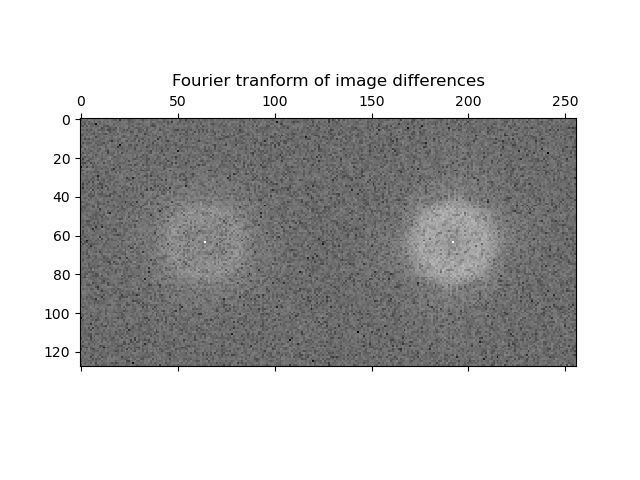

Text(0.5, 1.0, 'Fourier tranform of image differences')

In [28]:
#Let's plot them on the same figure so that we can more easily compare
ft_diff_frame1 = np.fft.fftshift(np.fft.fft2(1.0*im[1]-im[0]))
plt.figure()
plt.matshow(np.log(abs(np.hstack((ft_diff_frame1,ft_diff_frame100)))), fignum=0, cmap=plt.cm.gray)
plt.title("Fourier tranform of image differences")

What are some things you notice about the Fourier transforms?

Now, let's take *all* pairs of frames separated by some time (let's say 5 frames) and average together their Fourier transforms.

In [31]:
#First, let's initialize some array to hold this average
ft_diffs_5frames = np.zeros_like(ft_diff_frame1) #look up what 'zeros_like' does

#Loop through all frames. Let's not actually take *every* pair of images separated by 5
#  frames. Instead, we'll go in steps of 20 frames. So we'll find the difference between 
#  frame 1 and 6, 21 and 26, 41 and 46, etc.
j=0 #This variable is used as a counter in our running average
for i in range(0, im.shape[0]-5, 20):
    image_difference = 1.0*im[i+5] - im[i]
    ft_diffs_5frames = ft_diffs_5frames + np.fft.fftshift(np.fft.fft2(image_difference))
    j=j+1
ft_diffs_5frames = ft_diffs_5frames / j

<IPython.core.display.Javascript object>


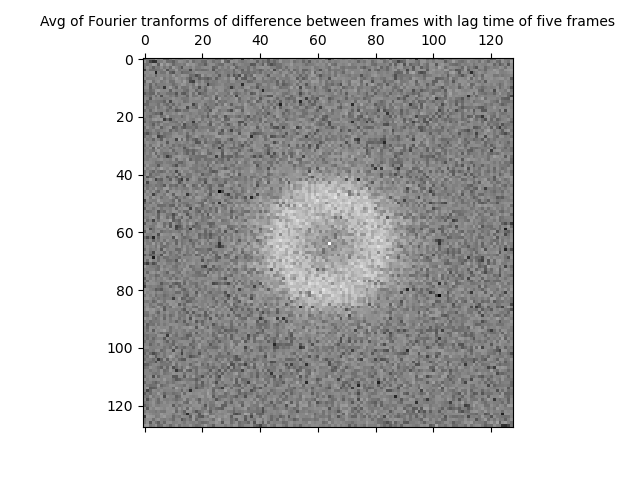

Text(0.5, 1.0, 'Avg of Fourier tranforms of difference between frames with lag time of five frames')

In [32]:
plt.figure()
plt.matshow(np.log(abs(ft_diffs_5frames)), fignum=0, cmap=plt.cm.gray)
plt.title("Avg of Fourier tranforms of difference between frames with lag time of five frames", fontsize=10)

Do something similar. But this time, find the average of the Fourier transforms of image differences with a lag time of: (a) 1 frame, (b) 50 frames, and (c) 200 frames. Show them all on the same figure side-by-side using 'hstack'.